#### Pretrained Модели используются как Baseline
#### В дальнейшем мы перешли на амописную модель (№3)

# Инструкция по настройке Kaggle в Google Colab ---> Получение данных

Инструкция по скачиванию датасета с Kaggle
Подходит,если у вас в GOOGLE COLAB старая версия кэггла стоит(старый способ аунтификации)


Шаг 1: Получение API токена Kaggle


1) Зайдите на Kaggle (https://www.kaggle.com)

2) Авторизуйтесь под своей учетной записью

3) Перейдите в настройки профиля: Нажмите на свою аватарку → Settings

4) Найдите секцию API: Прокрутите вниз до раздела "API"

5) Создайте токен: Нажмите "Create New API Token"

Шаг 2: Импортирование токена в проект
1) В разделе "Получение данных" вставте свой токен после "KAGGLE_API_TOKEN="

#Импорты и установка device

In [1]:
# Установка EfficientNet для второй модели
! pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=61fd85c8bc066892398159bbdffdc38a74c200880e6a7c2e2abe927c8aa030d6
  Stored in directory: /root/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
Successfully built efficientnet_pytorch


In [2]:
# Основные импорты
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Для работы с изображениями
import cv2
from PIL import Image
import os
from pathlib import Path

# ML и deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms import autoaugment
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, \
                            classification_report, roc_auc_score, accuracy_score
from efficientnet_pytorch import EfficientNet
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
from torchvision import models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import timm

#Дополнительные
import random
from google.colab import files
from google.colab import drive

In [3]:
# Установка device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


#Получение данных

Качаем датасет с Kaggle

In [4]:
! pip install --upgrade kaggle

%env KAGGLE_API_TOKEN=KGAT_1e96c9a7340ad4f098cf4b398012b8c2

! kaggle competitions download -c ml-intensive-yandex-academy-autumn-2025

! unzip  ml-intensive-yandex-academy-autumn-2025.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: dataset/train_images/55.jpg  
  inflating: dataset/train_images/550.jpg  
  inflating: dataset/train_images/5500.jpg  
  inflating: dataset/train_images/5501.jpg  
  inflating: dataset/train_images/5502.jpg  
  inflating: dataset/train_images/5503.jpg  
  inflating: dataset/train_images/5504.jpg  
  inflating: dataset/train_images/5505.jpg  
  inflating: dataset/train_images/5506.jpg  
  inflating: dataset/train_images/5507.jpg  
  inflating: dataset/train_images/5508.jpg  
  inflating: dataset/train_images/5509.jpg  
  inflating: dataset/train_images/551.jpg  
  inflating: dataset/train_images/5510.jpg  
  inflating: dataset/train_images/5511.jpg  
  inflating: dataset/train_images/5512.jpg  
  inflating: dataset/train_images/5513.jpg  
  inflating: dataset/train_images/5514.jpg  
  inflating: dataset/train_images/5515.jpg  
  inflating: dataset/train_images/5516.jpg  
  inflating: dataset/train_images/55

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


Проверяем, что все успешно сохранилось

In [6]:
data_solution = pd.read_csv("./dataset/train_solution.csv")
data_solution.head(10)

0  0.1
0   1    1
1   2    1
2   3    0
3   4    0
4   5    0
5   6    1
6   7    1
7   8    0
8   9    0
9  10    0

Вывод 10 случаных картинок(также проверяем на успешность сохранения датасета)

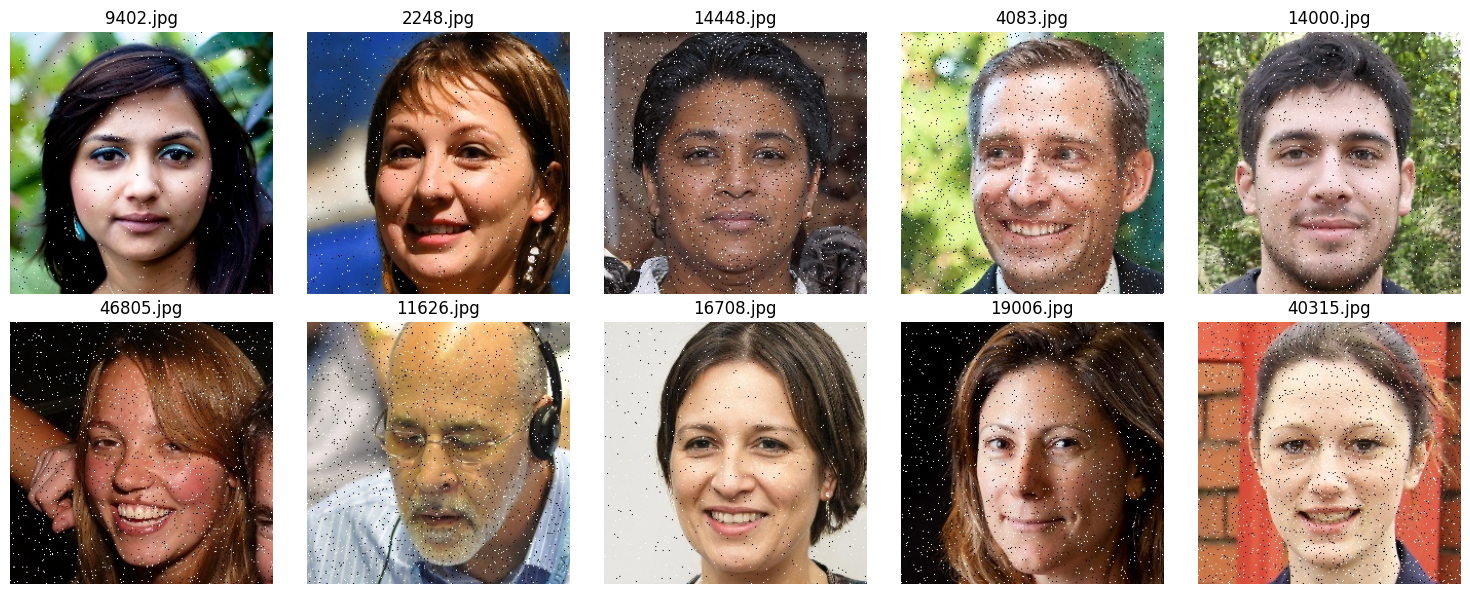

In [7]:
train_path = "./dataset/train_images"
image_files = [f for f in os.listdir(train_path)]

# 10 случайных картинок
selected_images = random.sample(image_files, min(10, len(image_files)))

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, img_name in enumerate(selected_images):
  img_path = os.path.join(train_path, img_name)
  img = Image.open(img_path)

  axes[i].imshow(img)
  axes[i].set_title(img_name)
  axes[i].axis('off')

plt.tight_layout()
plt.show()

#Анализ датасета

## Загружаем train и переименовываем колонки для удобства

In [8]:
train_df = pd.read_csv("./dataset/train_solution.csv")
train_df.columns = ['image_id', 'label']

print("ОБЩАЯ ИНФОРМАЦИЯ О ДАТАСЕТЕ")
print(f"Размер датасета: {len(train_df):,} изображений\n")
print(train_df.info())
print(f"\nПропущенные значения:\n{train_df.isnull().sum()}")

ОБЩАЯ ИНФОРМАЦИЯ О ДАТАСЕТЕ
Размер датасета: 49,999 изображений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   image_id  49999 non-null  int64
 1   label     49999 non-null  int64
dtypes: int64(2)
memory usage: 781.4 KB
None

Пропущенные значения:
image_id    0
label       0
dtype: int64


## Рассмотрение распределения ИИ-фоток и настоящих

Баланс классов:
  Класс 0 (REAL): 41,499 (83.0%)
  Класс 1 (FAKE): 8,500 (17.0%)
  Соотношение: 4.88 : 1


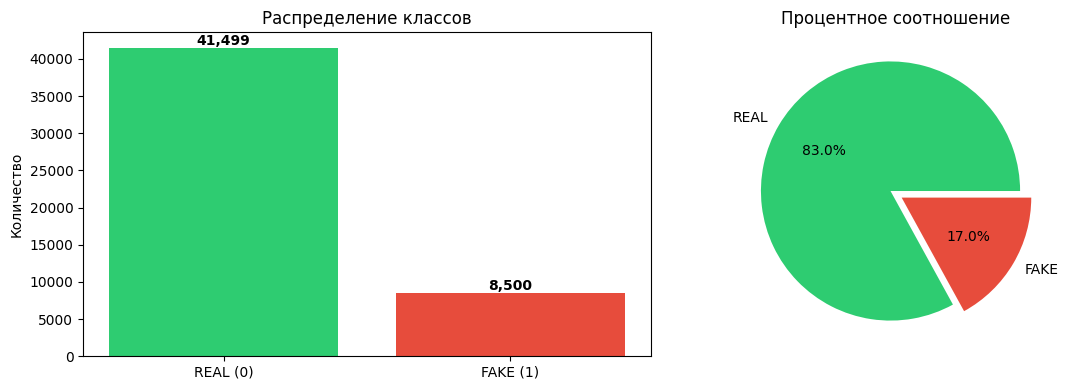

In [9]:
def analyze_class_balance(df):
  # Считаем количество примеров каждого класса
  class_counts = df['label'].value_counts().sort_index()
  class_0 = class_counts[0]
  class_1 = class_counts[1]
  ratio = class_0 / class_1

  print("Баланс классов:")
  print(f"  Класс 0 (REAL): {class_0:,} ({class_0/len(df)*100:.1f}%)")
  print(f"  Класс 1 (FAKE): {class_1:,} ({class_1/len(df)*100:.1f}%)")
  print(f"  Соотношение: {ratio:.2f} : 1")

  # Рисуем графики
  fig, axes = plt.subplots(1, 2, figsize=(12, 4))

  colors = ['#2ecc71', '#e74c3c']
  bars = axes[0].bar(['REAL (0)', 'FAKE (1)'], class_counts.values, color=colors)
  axes[0].set_title('Распределение классов')
  axes[0].set_ylabel('Количество')

  # Подписи над столбцами
  for bar in bars:
      height = bar.get_height()
      axes[0].text(bar.get_x() + bar.get_width()/2., height,
                  f'{int(height):,}', ha='center', va='bottom', fontweight='bold')

  # Круговая диаграмма
  axes[1].pie(class_counts.values, labels=['REAL', 'FAKE'],
              autopct='%1.1f%%', colors=colors, explode=(0.05, 0.05))
  axes[1].set_title('Процентное соотношение')

  plt.tight_layout()
  plt.show()

  return ratio

# Считаем imbalance ratio, пригодится для loss функции
imbalance_ratio = analyze_class_balance(train_df)

**ВАЖНО**: Сильный дисбаланс, Нужно использовать: pos_weight в Loss функции
F1-score как главную метрику не accuracy!
Stratified split для train/val

Вывод примера фоток, но уже с понимаем, где дипфейк, а где реальные

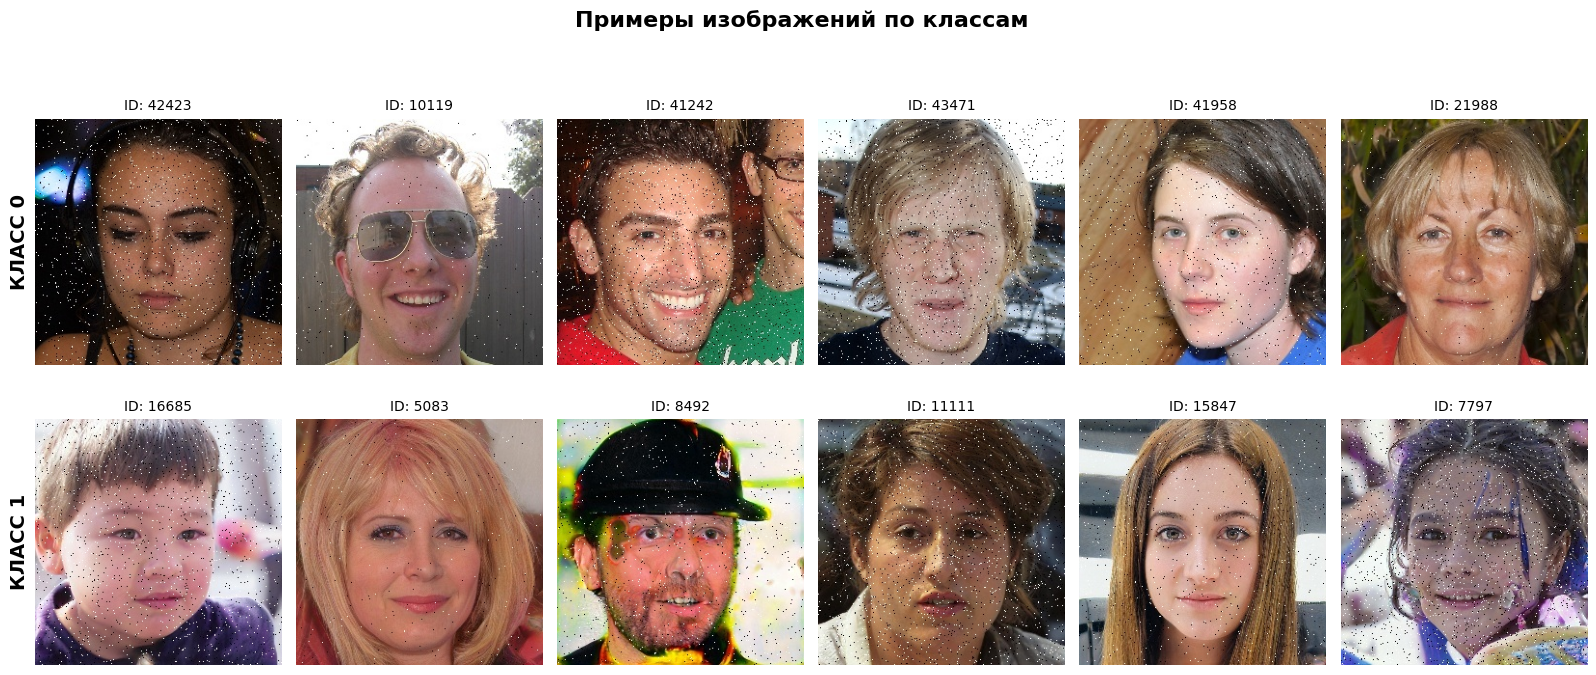

In [10]:
def show_class_samples(df, img_dir, file_ext, n_samples=5):

  fig, axes = plt.subplots(2, n_samples, figsize=(16, 7))

  for class_idx in [0, 1]:
    class_samples = df[df['label'] == class_idx].sample(n_samples, random_state=5252)

    for i, (_, row) in enumerate(class_samples.iterrows()):
      img_path = os.path.join(img_dir, f"{row['image_id']}{file_ext}")
      img = Image.open(img_path)

      axes[class_idx, i].imshow(img)
      axes[class_idx, i].set_title(f"ID: {row['image_id']}", fontsize=10)
      axes[class_idx, i].axis('off')

    axes[class_idx, 0].text(-0.1, 0.5, f'КЛАСС {class_idx}',
                            transform=axes[class_idx, 0].transAxes,
                            fontsize=14, fontweight='bold',
                            rotation=90, va='center')

  plt.suptitle('Примеры изображений по классам', fontsize=16, fontweight='bold', y=1.02)
  plt.tight_layout()
  plt.savefig('class_samples.png', dpi=150, bbox_inches='tight')
  plt.show()

show_class_samples(train_df, train_path, '.jpg', n_samples=6)

#МОДЕЛИ

## №1

### Конфигурация Модели

In [ ]:
class CONFIG:
  TRAIN_IMAGES = "./dataset/train_images"
  TEST_IMAGES = "./dataset/test_images"

  IMG_SIZE = 224
  BATCH_SIZE = 32
  EPOCHS = 15
  LR = 1e-4
  WEIGHT_DECAY = 1e-4

  VAL_SIZE = 0.2
  SEED = 42

  # Вес для minority класса, помогает бороться с дисбалансом
  POS_WEIGHT = imbalance_ratio

  DEVICE = device
  NUM_WORKERS = 2

  CLASS_NAMES = {0: 'REAL', 1: 'FAKE'}

print(f"Device: {CONFIG.DEVICE}")
print(f"Train images: {CONFIG.TRAIN_IMAGES}")
print(f"Test images: {CONFIG.TEST_IMAGES}")

Device: cuda
Train images: ./dataset/train_images
Test images: ./dataset/test_images


In [ ]:
class DeepfakeDataset(Dataset):
  def __init__(self, dataframe, img_dir, transform=None, is_test=False):
    self.df = dataframe.reset_index(drop=True)
    self.img_dir = img_dir
    self.transform = transform
    self.is_test = is_test

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img_id = self.df.loc[idx, 'image_id']
    img_path = os.path.join(self.img_dir, f"{img_id}.jpg")

    image = Image.open(img_path).convert('RGB')

    if self.transform:
        image = self.transform(image)

    if self.is_test:
        return image, img_id
    else:
        label = self.df.loc[idx, 'label']
        return image, torch.tensor(label, dtype=torch.float32)

In [ ]:
# Аугментации для трейна - добавляем немного шума
train_transform = transforms.Compose([
  transforms.Resize((CONFIG.IMG_SIZE, CONFIG.IMG_SIZE)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomRotation(10),
  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
  transforms.RandomApply([
      transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))
  ], p=0.2),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Для валидации только ресайз и нормализация
val_transform = transforms.Compose([
  transforms.Resize((CONFIG.IMG_SIZE, CONFIG.IMG_SIZE)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transforms готовы")

Transforms готовы


 НАЗНАЧЕНИЕ:
 1. Борьба с переобучением (overfitting) - модель учит общие признаки, а не запоминает конкретные изображения
 2. Искусственное увеличение размера тренировочного датасета
 3. Повышение обобщающей способности модели для работы в реальных условиях

In [ ]:
train_data, val_data = train_test_split(
  train_df,
  test_size=CONFIG.VAL_SIZE,
  random_state=CONFIG.SEED,
  stratify=train_df['label']  # сохраняем пропорции классов
)

print(f"Train: {len(train_data):,} изображений")
print(f"Val: {len(val_data):,} изображений")

train_dataset = DeepfakeDataset(train_data, CONFIG.TRAIN_IMAGES, transform=train_transform)
val_dataset = DeepfakeDataset(val_data, CONFIG.TRAIN_IMAGES, transform=val_transform)

train_loader = DataLoader(
  train_dataset,
  batch_size=CONFIG.BATCH_SIZE,
  shuffle=True,
  num_workers=CONFIG.NUM_WORKERS,
  pin_memory=True
)

val_loader = DataLoader(
  val_dataset,
  batch_size=CONFIG.BATCH_SIZE,
  shuffle=False,
  num_workers=CONFIG.NUM_WORKERS,
  pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train: 39,999 изображений
Val: 10,000 изображений
Train batches: 1250
Val batches: 313


### MODEL

Берем pretrained backbone и добавляем свою голову

In [ ]:
class DeepfakeDetector(nn.Module):
  def __init__(self, model_name='efficientnet_b0', pretrained=True, dropout=0.3):
    super(DeepfakeDetector, self).__init__()

    self.model_name = model_name

    if model_name == 'efficientnet_b0':
      # Загружаем предобученный EfficientNet
      self.backbone = models.efficientnet_b0(weights='IMAGENET1K_V1' if pretrained else None)
      num_features = self.backbone.classifier[1].in_features
      # Заменяем классификатор на свой
      self.backbone.classifier = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(512, 1)
      )

    elif model_name == 'resnet18':
      self.backbone = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)
      num_features = self.backbone.fc.in_features
      self.backbone.fc = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(num_features, 256),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(256, 1)
      )

    elif model_name == 'resnet50':
      self.backbone = models.resnet50(weights='IMAGENET1K_V1' if pretrained else None)
      num_features = self.backbone.fc.in_features
      self.backbone.fc = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(512, 1)
      )

  def forward(self, x):
    return self.backbone(x)

# Создаем модель и отправляем на GPU
model = DeepfakeDetector(model_name='efficientnet_b0', pretrained=True, dropout=0.4)
model = model.to(CONFIG.DEVICE)

# Смотрим сколько параметров
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model: EfficientNet-B0")
print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 137MB/s] 


Model: EfficientNet-B0
Total params: 4,663,933
Trainable params: 4,663,933


In [ ]:
# Функция потерь с весом для борьбы с дисбалансом
pos_weight = torch.tensor([CONFIG.POS_WEIGHT]).to(CONFIG.DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Оптимизатор с weight decay для регуляризации
optimizer = optim.AdamW(model.parameters(), lr=CONFIG.LR, weight_decay=CONFIG.WEIGHT_DECAY)

# Scheduler для плавного уменьшения lr
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG.EPOCHS, eta_min=1e-6)

print(f"Loss: BCEWithLogitsLoss (pos_weight={CONFIG.POS_WEIGHT:.2f})")
print(f"Optimizer: AdamW (lr={CONFIG.LR})")
print(f"Scheduler: CosineAnnealingLR")

Loss: BCEWithLogitsLoss (pos_weight=4.88)
Optimizer: AdamW (lr=0.0001)
Scheduler: CosineAnnealingLR


In [ ]:
# Функция для одной эпохи обучения
def train_epoch(model, loader, criterion, optimizer, device):
  model.train()
  running_loss = 0.0
  all_preds = []
  all_labels = []

  pbar = tqdm(loader, desc='Training')

  for images, labels in pbar:
    # Переносим данные на GPU
    images = images.to(device)
    labels = labels.to(device)

    # Обнуляем градиенты
    optimizer.zero_grad()

    # Forward pass
    outputs = model(images).squeeze()
    loss = criterion(outputs, labels)

    # Backward pass
    loss.backward()
    optimizer.step()

    # Собираем статистику
    running_loss += loss.item()
    preds = torch.sigmoid(outputs) > 0.5
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

    pbar.set_postfix({'loss': f'{loss.item():.4f}'})

  # Считаем средний loss и f1 за эпоху
  avg_loss = running_loss / len(loader)
  f1 = f1_score(all_labels, all_preds, zero_division=0)

  return avg_loss, f1


# Функция для валидации
def validate(model, loader, criterion, device):
  model.eval()
  running_loss = 0.0
  all_preds = []
  all_probs = []
  all_labels = []

  # Отключаем градиенты для ускорения
  with torch.no_grad():
    for images, labels in tqdm(loader, desc='Validation'):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images).squeeze()
      loss = criterion(outputs, labels)

      running_loss += loss.item()

      # Получаем вероятности через сигмоиду
      probs = torch.sigmoid(outputs)
      preds = probs > 0.5

      all_probs.extend(probs.cpu().numpy())
      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  # Считаем метрики
  avg_loss = running_loss / len(loader)
  f1 = f1_score(all_labels, all_preds, zero_division=0)
  precision = precision_score(all_labels, all_preds, zero_division=0)
  recall = recall_score(all_labels, all_preds, zero_division=0)

  # AUC может упасть если только один класс в предсказаниях
  try:
    auc = roc_auc_score(all_labels, all_probs)
  except:
    auc = 0.0

  return avg_loss, f1, precision, recall, auc, all_preds, all_labels

### Обучение

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                device, epochs, save_path='best_model.pth'):
  best_f1 = 0.0
  history = {
    'train_loss': [], 'val_loss': [],
    'train_f1': [], 'val_f1': [],
    'val_precision': [], 'val_recall': [], 'val_auc': []
  }

  for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-" * 40)

    # Обучаем одну эпоху
    train_loss, train_f1 = train_epoch(model, train_loader, criterion, optimizer, device)

    # Валидируем
    val_loss, val_f1, val_prec, val_rec, val_auc, _, _ = validate(model, val_loader, criterion, device)

    scheduler.step()

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)
    history['val_precision'].append(val_prec)
    history['val_recall'].append(val_rec)
    history['val_auc'].append(val_auc)

    print(f"Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")
    print(f"Precision: {val_prec:.4f} | Recall: {val_rec:.4f} | AUC: {val_auc:.4f}")

    # Сохраняем лучшую модель по f1
    if val_f1 > best_f1:
      best_f1 = val_f1
      torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_f1': best_f1,
        'history': history,
      }, save_path)
      print(f"Model saved! Best F1: {best_f1:.4f}")

  print(f"\nTraining complete. Best F1: {best_f1:.4f}")
  return history, best_f1

In [ ]:
# Запускаем обучение или загружаем готовую модель
model_path = 'deepfake_detector_best.pth'

if os.path.exists(model_path):
  print(f"Найдена обученная модель: {model_path}")
  checkpoint = torch.load(model_path, map_location=CONFIG.DEVICE)
  model.load_state_dict(checkpoint['model_state_dict'])
  best_f1 = checkpoint['best_f1']

  # Загружаеи history если она сохранена
  history = checkpoint.get('history', None)

  print(f"Best F1: {best_f1:.4f}, Epoch: {checkpoint['epoch']+1}")

else:
  print("Обученная модель не найдена, начинаем обучение...")
  history, best_f1 = train_model(
    model, train_loader, val_loader,
    criterion, optimizer, scheduler,
    CONFIG.DEVICE, CONFIG.EPOCHS,
    save_path=model_path
  )

Обученная модель не найдена, начинаем обучение...

Epoch 1/15
----------------------------------------


Validation: 100%|██████████| 313/313 [00:32<00:00,  9.66it/s]


Train Loss: 0.6664 | Train F1: 0.6076
Val Loss: 0.4555 | Val F1: 0.6723
Precision: 0.5152 | Recall: 0.9671 | AUC: 0.9698
Model saved! Best F1: 0.6723

Epoch 2/15
----------------------------------------


Validation: 100%|██████████| 313/313 [00:32<00:00,  9.55it/s]


Train Loss: 0.3589 | Train F1: 0.7714
Val Loss: 0.2436 | Val F1: 0.8208
Precision: 0.7136 | Recall: 0.9659 | AUC: 0.9881
Model saved! Best F1: 0.8208

Epoch 3/15
----------------------------------------


Validation: 100%|██████████| 313/313 [00:31<00:00, 10.07it/s]


Train Loss: 0.2472 | Train F1: 0.8427
Val Loss: 0.1988 | Val F1: 0.8602
Precision: 0.7739 | Recall: 0.9682 | AUC: 0.9917
Model saved! Best F1: 0.8602

Epoch 4/15
----------------------------------------


Validation: 100%|██████████| 313/313 [00:32<00:00,  9.71it/s]


Train Loss: 0.1960 | Train F1: 0.8731
Val Loss: 0.1994 | Val F1: 0.8312
Precision: 0.7182 | Recall: 0.9865 | AUC: 0.9947

Epoch 5/15
----------------------------------------


Validation: 100%|██████████| 313/313 [00:31<00:00,  9.78it/s]


Train Loss: 0.1540 | Train F1: 0.8964
Val Loss: 0.1559 | Val F1: 0.8764
Precision: 0.7938 | Recall: 0.9782 | AUC: 0.9954
Model saved! Best F1: 0.8764

Epoch 6/15
----------------------------------------


Validation: 100%|██████████| 313/313 [00:32<00:00,  9.78it/s]


Train Loss: 0.1193 | Train F1: 0.9184
Val Loss: 0.1435 | Val F1: 0.9051
Precision: 0.8460 | Recall: 0.9729 | AUC: 0.9962
Model saved! Best F1: 0.9051

Epoch 7/15
----------------------------------------


Validation: 100%|██████████| 313/313 [00:32<00:00,  9.63it/s]


Train Loss: 0.0990 | Train F1: 0.9314
Val Loss: 0.1701 | Val F1: 0.8665
Precision: 0.7711 | Recall: 0.9888 | AUC: 0.9966

Epoch 8/15
----------------------------------------


Validation: 100%|██████████| 313/313 [00:32<00:00,  9.49it/s]


Train Loss: 0.0785 | Train F1: 0.9452
Val Loss: 0.1483 | Val F1: 0.8854
Precision: 0.8001 | Recall: 0.9912 | AUC: 0.9971

Epoch 9/15
----------------------------------------


Validation: 100%|██████████| 313/313 [00:32<00:00,  9.60it/s]


Train Loss: 0.0670 | Train F1: 0.9498
Val Loss: 0.1241 | Val F1: 0.9169
Precision: 0.8611 | Recall: 0.9806 | AUC: 0.9971
Model saved! Best F1: 0.9169

Epoch 10/15
----------------------------------------


Validation: 100%|██████████| 313/313 [00:32<00:00,  9.71it/s]


Train Loss: 0.0573 | Train F1: 0.9626
Val Loss: 0.1100 | Val F1: 0.9359
Precision: 0.8931 | Recall: 0.9829 | AUC: 0.9976
Model saved! Best F1: 0.9359

Epoch 11/15
----------------------------------------


Validation: 100%|██████████| 313/313 [00:32<00:00,  9.78it/s]


Train Loss: 0.0413 | Train F1: 0.9719
Val Loss: 0.1080 | Val F1: 0.9418
Precision: 0.9060 | Recall: 0.9806 | AUC: 0.9979
Model saved! Best F1: 0.9418

Epoch 12/15
----------------------------------------


Validation: 100%|██████████| 313/313 [00:31<00:00,  9.87it/s]


Train Loss: 0.0421 | Train F1: 0.9734
Val Loss: 0.1039 | Val F1: 0.9335
Precision: 0.8859 | Recall: 0.9865 | AUC: 0.9981

Epoch 13/15
----------------------------------------


Validation: 100%|██████████| 313/313 [00:32<00:00,  9.69it/s]


Train Loss: 0.0324 | Train F1: 0.9791
Val Loss: 0.1022 | Val F1: 0.9509
Precision: 0.9244 | Recall: 0.9788 | AUC: 0.9982
Model saved! Best F1: 0.9509

Epoch 14/15
----------------------------------------


Validation: 100%|██████████| 313/313 [00:31<00:00,  9.82it/s]


Train Loss: 0.0313 | Train F1: 0.9806
Val Loss: 0.1004 | Val F1: 0.9400
Precision: 0.8982 | Recall: 0.9859 | AUC: 0.9982

Epoch 15/15
----------------------------------------


Validation: 100%|██████████| 313/313 [00:32<00:00,  9.63it/s]


Train Loss: 0.0257 | Train F1: 0.9822
Val Loss: 0.0993 | Val F1: 0.9404
Precision: 0.9000 | Recall: 0.9847 | AUC: 0.9983

Training complete. Best F1: 0.9509


### Графики после обучения

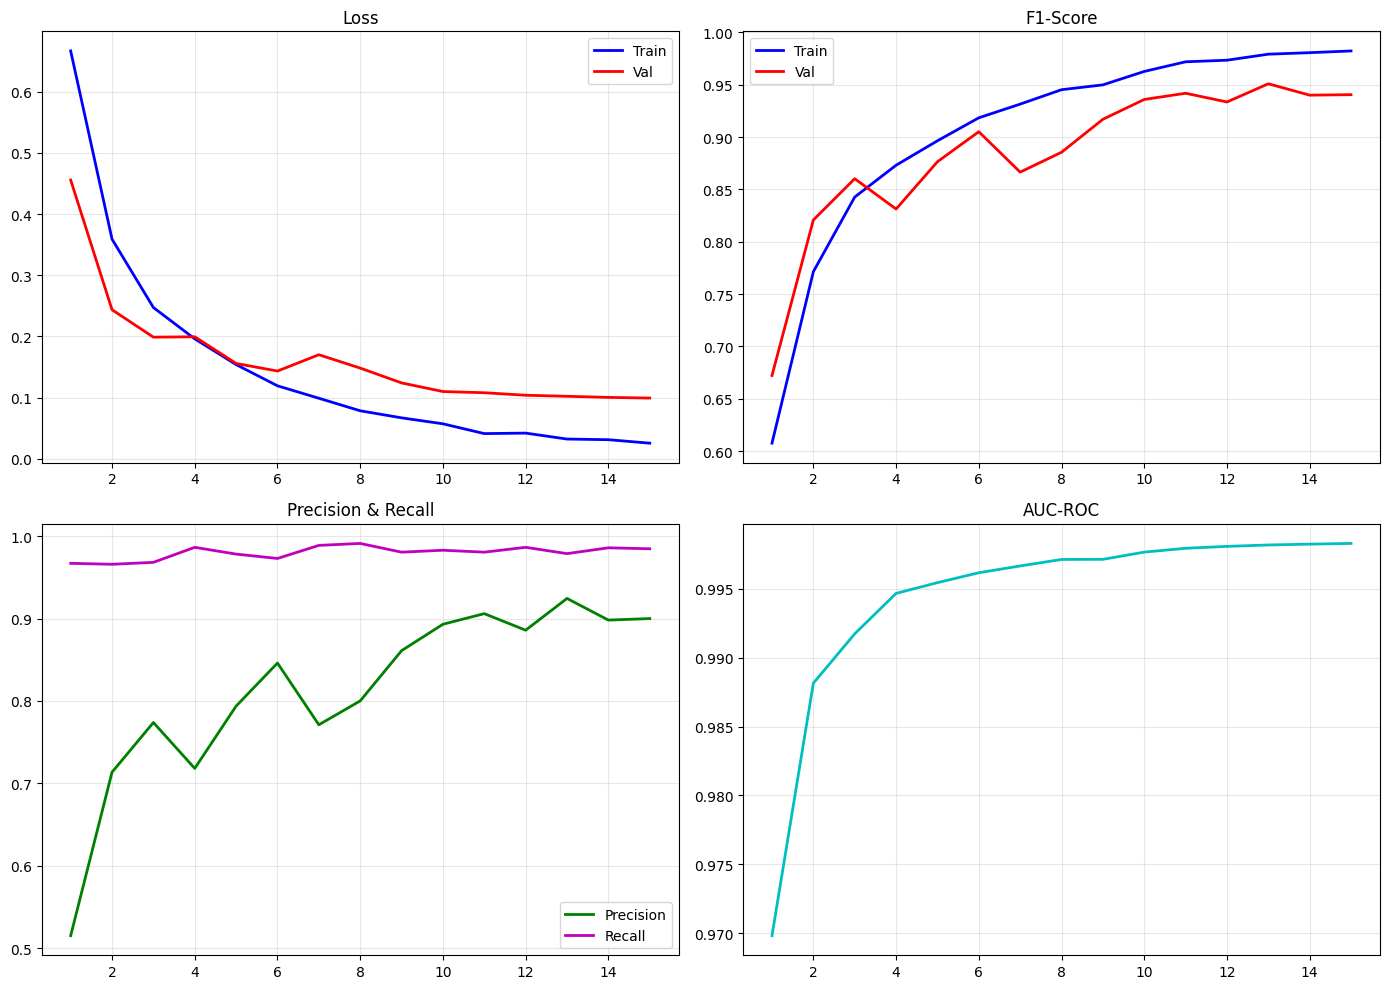

In [ ]:
def plot_history(history):
  fig, axes = plt.subplots(2, 2, figsize=(14, 10))
  epochs = range(1, len(history['train_loss']) + 1)

  # Loss
  axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
  axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val', linewidth=2)
  axes[0, 0].set_title('Loss')
  axes[0, 0].legend()
  axes[0, 0].grid(True, alpha=0.3)

  # F1
  axes[0, 1].plot(epochs, history['train_f1'], 'b-', label='Train', linewidth=2)
  axes[0, 1].plot(epochs, history['val_f1'], 'r-', label='Val', linewidth=2)
  axes[0, 1].set_title('F1-Score')
  axes[0, 1].legend()
  axes[0, 1].grid(True, alpha=0.3)

  # Precision и Recall
  axes[1, 0].plot(epochs, history['val_precision'], 'g-', label='Precision', linewidth=2)
  axes[1, 0].plot(epochs, history['val_recall'], 'm-', label='Recall', linewidth=2)
  axes[1, 0].set_title('Precision & Recall')
  axes[1, 0].legend()
  axes[1, 0].grid(True, alpha=0.3)

  # AUC
  axes[1, 1].plot(epochs, history['val_auc'], 'c-', linewidth=2)
  axes[1, 1].set_title('AUC-ROC')
  axes[1, 1].grid(True, alpha=0.3)

  plt.tight_layout()
  plt.savefig('training_history.png', dpi=150)
  plt.show()


if history is not None:
  plot_history(history)
else:
  print("Графики недоступны - модель была загружена из файла")

### Результаты

Loaded best model with F1 = 0.9509


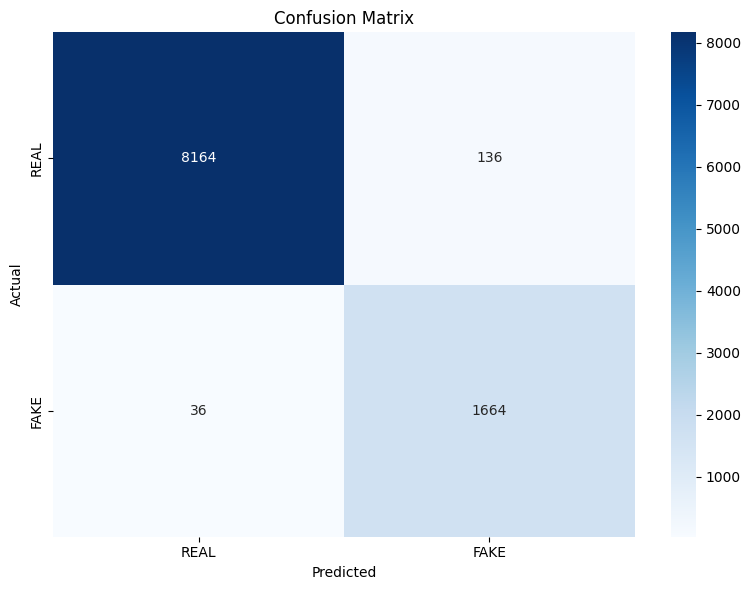


Classification Report:
              precision    recall  f1-score   support

        REAL       1.00      0.98      0.99      8300
        FAKE       0.92      0.98      0.95      1700

    accuracy                           0.98     10000
   macro avg       0.96      0.98      0.97     10000
weighted avg       0.98      0.98      0.98     10000



In [ ]:
def evaluate_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images).squeeze()
            preds = torch.sigmoid(outputs) > 0.5
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['REAL', 'FAKE'],
                yticklabels=['REAL', 'FAKE'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['REAL', 'FAKE']))

# Загружаем лучший чекпоинт
checkpoint = torch.load('deepfake_detector_best.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model with F1 = {checkpoint['best_f1']:.4f}")

evaluate_model(model, val_loader, CONFIG.DEVICE)

### Создание файла для проверки score на Kaggle

In [ ]:
# Генерация предсказаний для тестовой выборки
def create_submission(model, test_path, transform, device, output_path='submission.csv'):
  model.eval()

  # Получаем список файлов в тестовой папке
  test_files = os.listdir(test_path)
  test_ids = [f.replace('.jpg', '') for f in test_files]

  # Создаем датафрейм для датасета
  test_df = pd.DataFrame({'image_id': test_ids})

  # Создаем датасет и лоадер
  test_dataset = DeepfakeDataset(test_df, test_path, transform=transform, is_test=True)
  test_loader = DataLoader(test_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False, num_workers=2)

  all_ids = []
  all_probs = []

  # Прогоняем все картинки через модель
  with torch.no_grad():
    for images, img_ids in tqdm(test_loader, desc='Predicting'):
      images = images.to(device)
      outputs = model(images).squeeze()
      probs = torch.sigmoid(outputs)

      all_ids.extend(img_ids)
      all_probs.extend(probs.cpu().numpy())

  # Формируем submission файл
  submission = pd.DataFrame({
      'image_id': all_ids,
      'label': (np.array(all_probs) > 0.5).astype(int)
  })

  submission.to_csv(output_path, index=False)
  print(f"Submission saved: {output_path}")
  print(f"Total: {len(submission)}")
  print(f"Distribution:\n{submission['label'].value_counts()}")

  return submission

submission = create_submission(
    model,
    CONFIG.TEST_IMAGES,
    val_transform,
    CONFIG.DEVICE
)

Predicting: 100%|██████████| 313/313 [00:37<00:00,  8.31it/s]

Submission saved: submission.csv
Total: 10000
Distribution:
label
0    8226
1    1774
Name: count, dtype: int64


In [ ]:
# Скачиваем результаты

files.download('deepfake_detector_best.pth')
files.download('submission.csv')
files.download('training_history.png')

## №2

### Конфигурация Модели №2

In [ ]:
class CONFIG_V2:
  TRAIN_IMAGES = "./dataset/train_images"
  TEST_IMAGES = "./dataset/test_images"

  IMG_SIZE = 256
  BATCH_SIZE = 16
  EPOCHS = 20
  LR = 3e-5
  WEIGHT_DECAY = 1e-5

  VAL_SIZE = 0.15
  SEED = 2023

  # Более агрессивная балансировка
  POS_WEIGHT = imbalance_ratio * 2

  DEVICE = device
  NUM_WORKERS = 4

  MODEL_NAME = 'efficientnet_b3'

  # Новые параметры для улучшения обучения
  USE_MIXUP = True
  USE_CUTMIX = True
  SCHEDULER = 'CosineAnnealing'
  DROPOUT_RATE = 0.3

  CLASS_NAMES = {0: 'REAL', 1: 'FAKE'}

Более агрессивные аугментации для второй модели

In [ ]:
train_transform_v2 = transforms.Compose([
    transforms.Resize((CONFIG_V2.IMG_SIZE, CONFIG_V2.IMG_SIZE)),
    autoaugment.TrivialAugmentWide(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3,
                          saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform_v2 = transforms.Compose([
    transforms.Resize((CONFIG_V2.IMG_SIZE, CONFIG_V2.IMG_SIZE)),
    transforms.CenterCrop(CONFIG_V2.IMG_SIZE),  # Центральный кроп
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

Кастомный Dataset с MixUp и CutMix

In [ ]:
class AdvancedDeepfakeDataset(Dataset):
  def __init__(self, dataframe, img_dir, transform=None,
              is_test=False, use_mixup=False, use_cutmix=False):
    self.df = dataframe.reset_index(drop=True)
    self.img_dir = img_dir
    self.transform = transform
    self.is_test = is_test
    self.use_mixup = use_mixup
    self.use_cutmix = use_cutmix

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img_id = self.df.loc[idx, 'image_id']
    img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
    image = Image.open(img_path).convert('RGB')

    if self.transform:
        image = self.transform(image)

    if self.is_test:
        return image, img_id
    else:
        label = self.df.loc[idx, 'label']
        return image, torch.tensor(label, dtype=torch.float32)

Создание датасетов и даталоадеров для второй модели

In [ ]:
# Разделение данных с другим random_state
train_data_v2, val_data_v2 = train_test_split(
    train_df,
    test_size=CONFIG_V2.VAL_SIZE,
    random_state=CONFIG_V2.SEED,
    stratify=train_df['label']
)

print(f"Вторая модель:")
print(f"Train: {len(train_data_v2):,} изображений")
print(f"Val: {len(val_data_v2):,} изображений")

# Создаем датасеты с новыми трансформациями
train_dataset_v2 = AdvancedDeepfakeDataset(
    train_data_v2,
    CONFIG_V2.TRAIN_IMAGES,
    transform=train_transform_v2,
    use_mixup=CONFIG_V2.USE_MIXUP,
    use_cutmix=CONFIG_V2.USE_CUTMIX
)

val_dataset_v2 = AdvancedDeepfakeDataset(
    val_data_v2,
    CONFIG_V2.TRAIN_IMAGES,
    transform=val_transform_v2
)

# DataLoader с другими параметрами
train_loader_v2 = DataLoader(
    train_dataset_v2,
    batch_size=CONFIG_V2.BATCH_SIZE,
    shuffle=True,
    num_workers=CONFIG_V2.NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

val_loader_v2 = DataLoader(
    val_dataset_v2,
    batch_size=CONFIG_V2.BATCH_SIZE,
    shuffle=False,
    num_workers=CONFIG_V2.NUM_WORKERS,
    pin_memory=True
)

print(f"Train batches: {len(train_loader_v2)}")
print(f"Val batches: {len(val_loader_v2)}")

Вторая модель:
Train: 42,499 изображений
Val: 7,500 изображений
Train batches: 2656
Val batches: 469


Создание модели

In [ ]:
model_v2 = EfficientNet.from_pretrained('efficientnet-b3')
num_ftrs = model_v2._fc.in_features
model_v2._fc = nn.Linear(num_ftrs, 1)  # Бинарная классификация
model_v2 = model_v2.to(CONFIG_V2.DEVICE)

print(f"Вторая модель создана: {CONFIG_V2.MODEL_NAME}")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


100%|██████████| 47.1M/47.1M [00:00<00:00, 201MB/s]


Loaded pretrained weights for efficientnet-b3
Вторая модель создана: efficientnet_b3


Оптимизатор и scheduler

In [ ]:
optimizer_v2 = torch.optim.AdamW(
    model_v2.parameters(),
    lr=CONFIG_V2.LR,
    weight_decay=CONFIG_V2.WEIGHT_DECAY
)

# Cosine Annealing Scheduler
scheduler_v2 = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_v2,
    T_max=CONFIG_V2.EPOCHS
)

# Функция потерь с учетом весов классов
pos_weight = torch.tensor([CONFIG_V2.POS_WEIGHT]).to(CONFIG_V2.DEVICE)
criterion_v2 = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

### MODEL №2 (EfficientNet)

Функция для обучения модели

In [ ]:
def train_model_v2(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
  history = {
      'train_loss': [],
      'val_loss': [],
      'val_accuracy': [],
      'val_f1': [],
      'val_roc_auc': [],
      'learning_rate': []
  }

  best_val_f1 = 0.0
  best_model_wts = None

  for epoch in range(num_epochs):
    print(f"\n{'='*60}")
    print(f"Эпоха {epoch+1}/{num_epochs}")
    print(f"{'='*60}")

    # Фаза обучения
    model.train()
    train_loss = 0.0
    train_samples = 0

    train_bar = tqdm(train_loader, desc=f'Обучение')
    for batch_idx, (images, labels) in enumerate(train_bar):
      images, labels = images.to(device), labels.to(device).unsqueeze(1)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()

      # Gradient clipping для стабильности
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

      optimizer.step()

      train_loss += loss.item() * images.size(0)
      train_samples += images.size(0)

      train_bar.set_postfix({
          'loss': loss.item(),
          'lr': optimizer.param_groups[0]['lr']
      })

    avg_train_loss = train_loss / train_samples
    history['train_loss'].append(avg_train_loss)
    history['learning_rate'].append(optimizer.param_groups[0]['lr'])

    # Фаза валидации
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
      val_bar = tqdm(val_loader, desc='Валидация')
      for images, labels in val_bar:
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        outputs = model(images)
        loss = criterion(outputs, labels)

        val_loss += loss.item() * images.size(0)

        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader.dataset)
    history['val_loss'].append(avg_val_loss)

    # Рассчитываем метрики
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)

    history['val_accuracy'].append(accuracy)
    history['val_f1'].append(f1)
    history['val_roc_auc'].append(roc_auc)

    # Сохраняем лучшую модель
    if f1 > best_val_f1:
        best_val_f1 = f1
        best_model_wts = model.state_dict().copy()
        print(f"F1-Score: {f1:.4f}")

    scheduler.step()

    print(f"\nРезультаты эпохи {epoch+1}:")
    print(f"   Train Loss: {avg_train_loss:.4f}")
    print(f"   Val Loss:   {avg_val_loss:.4f}")
    print(f"   Val Accuracy: {accuracy:.4f}")
    print(f"   Val F1-Score: {f1:.4f}")
    print(f"   Val ROC-AUC:  {roc_auc:.4f}")
    print(f"   Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")

  # Загружаем веса лучшей модели
  model.load_state_dict(best_model_wts)

  return model, history

Обучение модели

In [ ]:
model_v2_trained, history_v2 = train_model_v2(
    model=model_v2,
    train_loader=train_loader_v2,
    val_loader=val_loader_v2,
    criterion=criterion_v2,
    optimizer=optimizer_v2,
    scheduler=scheduler_v2,
    num_epochs=CONFIG_V2.EPOCHS,
    device=CONFIG_V2.DEVICE
)

print("\n" + "="*60)
print("ОБУЧЕНИЕ ВТОРОЙ МОДЕЛИ ЗАВЕРШЕНО!")
print("="*60)


Эпоха 1/20


Валидация: 100%|██████████| 469/469 [00:35<00:00, 13.09it/s]


F1-Score: 0.6940

Результаты эпохи 1:
   Train Loss: 1.2875
   Val Loss:   0.6711
   Val Accuracy: 0.8639
   Val F1-Score: 0.6940
   Val ROC-AUC:  0.9509
   Learning Rate: 2.98e-05

Эпоха 2/20


Валидация: 100%|██████████| 469/469 [00:35<00:00, 13.07it/s]


F1-Score: 0.7428

Результаты эпохи 2:
   Train Loss: 1.0287
   Val Loss:   0.4538
   Val Accuracy: 0.8876
   Val F1-Score: 0.7428
   Val ROC-AUC:  0.9774
   Learning Rate: 2.93e-05

Эпоха 3/20


Валидация: 100%|██████████| 469/469 [00:35<00:00, 13.25it/s]


F1-Score: 0.8522

Результаты эпохи 3:
   Train Loss: 0.9462
   Val Loss:   0.3610
   Val Accuracy: 0.9440
   Val F1-Score: 0.8522
   Val ROC-AUC:  0.9872
   Learning Rate: 2.84e-05

Эпоха 4/20


Валидация: 100%|██████████| 469/469 [00:35<00:00, 13.34it/s]


F1-Score: 0.8759

Результаты эпохи 4:
   Train Loss: 0.8613
   Val Loss:   0.2550
   Val Accuracy: 0.9533
   Val F1-Score: 0.8759
   Val ROC-AUC:  0.9930
   Learning Rate: 2.71e-05

Эпоха 5/20


Валидация: 100%|██████████| 469/469 [00:34<00:00, 13.41it/s]



Результаты эпохи 5:
   Train Loss: 0.8084
   Val Loss:   0.2257
   Val Accuracy: 0.9495
   Val F1-Score: 0.8684
   Val ROC-AUC:  0.9948
   Learning Rate: 2.56e-05

Эпоха 6/20


Валидация: 100%|██████████| 469/469 [00:35<00:00, 13.32it/s]


F1-Score: 0.8836

Результаты эпохи 6:
   Train Loss: 0.7572
   Val Loss:   0.2044
   Val Accuracy: 0.9560
   Val F1-Score: 0.8836
   Val ROC-AUC:  0.9959
   Learning Rate: 2.38e-05

Эпоха 7/20


Валидация: 100%|██████████| 469/469 [00:35<00:00, 13.23it/s]



Результаты эпохи 7:
   Train Loss: 0.7537
   Val Loss:   0.2232
   Val Accuracy: 0.9395
   Val F1-Score: 0.8477
   Val ROC-AUC:  0.9969
   Learning Rate: 2.18e-05

Эпоха 8/20


Валидация: 100%|██████████| 469/469 [00:35<00:00, 13.36it/s]


F1-Score: 0.9087

Результаты эпохи 8:
   Train Loss: 0.7125
   Val Loss:   0.1875
   Val Accuracy: 0.9665
   Val F1-Score: 0.9087
   Val ROC-AUC:  0.9972
   Learning Rate: 1.96e-05

Эпоха 9/20


Валидация: 100%|██████████| 469/469 [00:35<00:00, 13.26it/s]


F1-Score: 0.9313

Результаты эпохи 9:
   Train Loss: 0.6893
   Val Loss:   0.1636
   Val Accuracy: 0.9753
   Val F1-Score: 0.9313
   Val ROC-AUC:  0.9978
   Learning Rate: 1.73e-05

Эпоха 10/20


Валидация: 100%|██████████| 469/469 [00:35<00:00, 13.35it/s]


F1-Score: 0.9487

Результаты эпохи 10:
   Train Loss: 0.6620
   Val Loss:   0.1620
   Val Accuracy: 0.9820
   Val F1-Score: 0.9487
   Val ROC-AUC:  0.9981
   Learning Rate: 1.50e-05

Эпоха 11/20


Валидация: 100%|██████████| 469/469 [00:35<00:00, 13.27it/s]


F1-Score: 0.9518

Результаты эпохи 11:
   Train Loss: 0.6369
   Val Loss:   0.1471
   Val Accuracy: 0.9831
   Val F1-Score: 0.9518
   Val ROC-AUC:  0.9982
   Learning Rate: 1.27e-05

Эпоха 12/20


Валидация: 100%|██████████| 469/469 [00:35<00:00, 13.12it/s]



Результаты эпохи 12:
   Train Loss: 0.6229
   Val Loss:   0.1414
   Val Accuracy: 0.9828
   Val F1-Score: 0.9511
   Val ROC-AUC:  0.9984
   Learning Rate: 1.04e-05

Эпоха 13/20


Валидация: 100%|██████████| 469/469 [00:35<00:00, 13.26it/s]


F1-Score: 0.9618

Результаты эпохи 13:
   Train Loss: 0.6064
   Val Loss:   0.1247
   Val Accuracy: 0.9867
   Val F1-Score: 0.9618
   Val ROC-AUC:  0.9987
   Learning Rate: 8.19e-06

Эпоха 14/20


Валидация: 100%|██████████| 469/469 [00:34<00:00, 13.42it/s]



Результаты эпохи 14:
   Train Loss: 0.5725
   Val Loss:   0.1171
   Val Accuracy: 0.9839
   Val F1-Score: 0.9541
   Val ROC-AUC:  0.9988
   Learning Rate: 6.18e-06

Эпоха 15/20


Валидация: 100%|██████████| 469/469 [00:35<00:00, 13.35it/s]


F1-Score: 0.9666

Результаты эпохи 15:
   Train Loss: 0.5373
   Val Loss:   0.1168
   Val Accuracy: 0.9884
   Val F1-Score: 0.9666
   Val ROC-AUC:  0.9990
   Learning Rate: 4.39e-06

Эпоха 16/20


Валидация: 100%|██████████| 469/469 [00:34<00:00, 13.41it/s]



Результаты эпохи 16:
   Train Loss: 0.5493
   Val Loss:   0.1205
   Val Accuracy: 0.9848
   Val F1-Score: 0.9568
   Val ROC-AUC:  0.9990
   Learning Rate: 2.86e-06

Эпоха 17/20


Валидация: 100%|██████████| 469/469 [00:35<00:00, 13.20it/s]


F1-Score: 0.9666

Результаты эпохи 17:
   Train Loss: 0.5570
   Val Loss:   0.1131
   Val Accuracy: 0.9884
   Val F1-Score: 0.9666
   Val ROC-AUC:  0.9992
   Learning Rate: 1.63e-06

Эпоха 18/20


Валидация: 100%|██████████| 469/469 [00:34<00:00, 13.44it/s]



Результаты эпохи 18:
   Train Loss: 0.5275
   Val Loss:   0.1154
   Val Accuracy: 0.9861
   Val F1-Score: 0.9604
   Val ROC-AUC:  0.9991
   Learning Rate: 7.34e-07

Эпоха 19/20


Валидация: 100%|██████████| 469/469 [00:35<00:00, 13.39it/s]



Результаты эпохи 19:
   Train Loss: 0.5377
   Val Loss:   0.1118
   Val Accuracy: 0.9875
   Val F1-Score: 0.9640
   Val ROC-AUC:  0.9991
   Learning Rate: 1.85e-07

Эпоха 20/20


Валидация: 100%|██████████| 469/469 [00:35<00:00, 13.30it/s]


Результаты эпохи 20:
   Train Loss: 0.5611
   Val Loss:   0.1106
   Val Accuracy: 0.9868
   Val F1-Score: 0.9622
   Val ROC-AUC:  0.9991
   Learning Rate: 0.00e+00

ОБУЧЕНИЕ ВТОРОЙ МОДЕЛИ ЗАВЕРШЕНО!


Визуализация результатов

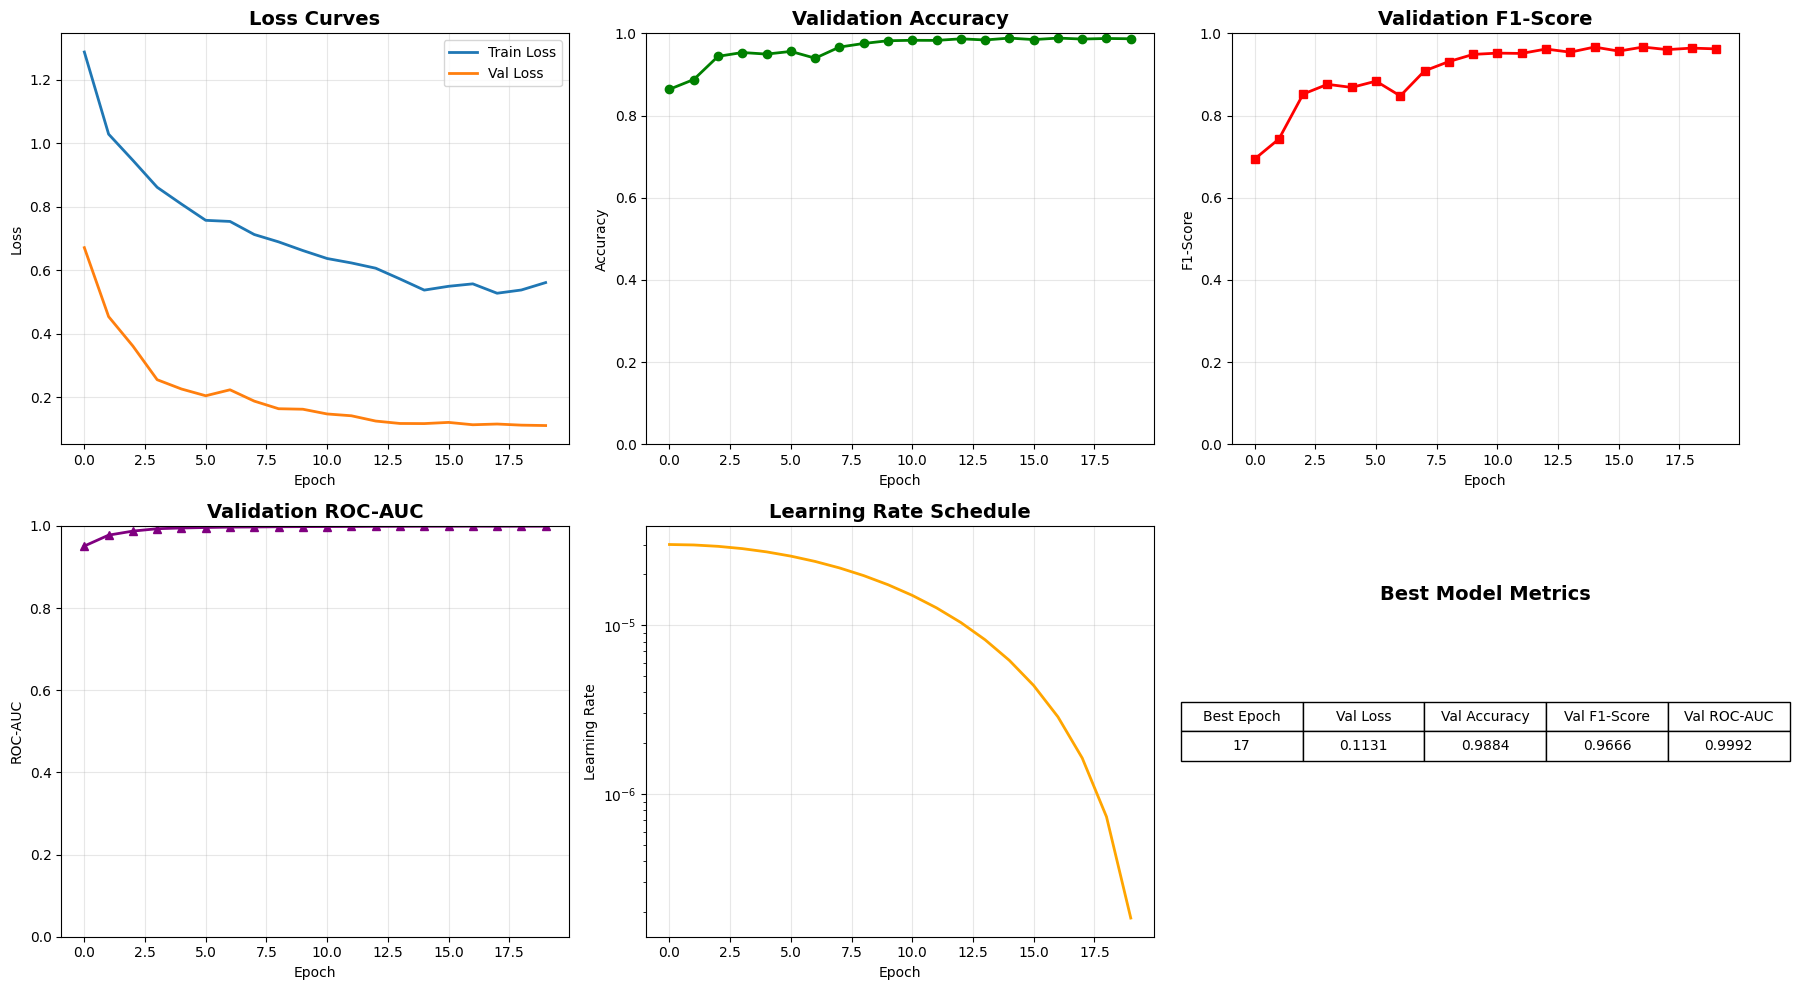

In [ ]:
def plot_training_history_v2(history):
  fig, axes = plt.subplots(2, 3, figsize=(18, 10))

  # Loss curves
  axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
  axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
  axes[0, 0].set_title('Loss Curves', fontsize=14, fontweight='bold')
  axes[0, 0].set_xlabel('Epoch')
  axes[0, 0].set_ylabel('Loss')
  axes[0, 0].legend()
  axes[0, 0].grid(True, alpha=0.3)

  # Accuracy
  axes[0, 1].plot(history['val_accuracy'], label='Val Accuracy',
                  color='green', linewidth=2, marker='o')
  axes[0, 1].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
  axes[0, 1].set_xlabel('Epoch')
  axes[0, 1].set_ylabel('Accuracy')
  axes[0, 1].set_ylim([0, 1])
  axes[0, 1].grid(True, alpha=0.3)

  # F1-Score
  axes[0, 2].plot(history['val_f1'], label='Val F1-Score',
                  color='red', linewidth=2, marker='s')
  axes[0, 2].set_title('Validation F1-Score', fontsize=14, fontweight='bold')
  axes[0, 2].set_xlabel('Epoch')
  axes[0, 2].set_ylabel('F1-Score')
  axes[0, 2].set_ylim([0, 1])
  axes[0, 2].grid(True, alpha=0.3)

  # ROC-AUC
  axes[1, 0].plot(history['val_roc_auc'], label='Val ROC-AUC',
                  color='purple', linewidth=2, marker='^')
  axes[1, 0].set_title('Validation ROC-AUC', fontsize=14, fontweight='bold')
  axes[1, 0].set_xlabel('Epoch')
  axes[1, 0].set_ylabel('ROC-AUC')
  axes[1, 0].set_ylim([0, 1])
  axes[1, 0].grid(True, alpha=0.3)

  # Learning Rate
  axes[1, 1].plot(history['learning_rate'], label='Learning Rate',
                  color='orange', linewidth=2)
  axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
  axes[1, 1].set_xlabel('Epoch')
  axes[1, 1].set_ylabel('Learning Rate')
  axes[1, 1].set_yscale('log')
  axes[1, 1].grid(True, alpha=0.3)

  # Сводная таблица лучших результатов
  best_epoch = np.argmax(history['val_f1'])
  metrics_data = {
      'Metric': ['Best Epoch', 'Val Loss', 'Val Accuracy', 'Val F1-Score', 'Val ROC-AUC'],
      'Value': [
          best_epoch + 1,
          f"{history['val_loss'][best_epoch]:.4f}",
          f"{history['val_accuracy'][best_epoch]:.4f}",
          f"{history['val_f1'][best_epoch]:.4f}",
          f"{history['val_roc_auc'][best_epoch]:.4f}"
      ]
  }

  axes[1, 2].axis('off')
  table = axes[1, 2].table(
      cellText=[metrics_data['Value']],
      colLabels=metrics_data['Metric'],
      cellLoc='center',
      loc='center'
  )
  table.auto_set_font_size(False)
  table.set_fontsize(10)
  table.scale(1.2, 1.5)
  axes[1, 2].set_title('Best Model Metrics', fontsize=14, fontweight='bold', y=0.8)

  plt.tight_layout()
  plt.show()

# Визуализация
plot_training_history_v2(history_v2)

Сохранение модели

In [ ]:
from datetime import datetime

config_dict = {k: v for k, v in CONFIG_V2.__dict__.items() if not k.startswith('__')}

torch.save({
    'model_state_dict': model_v2_trained.state_dict(),
    'optimizer_state_dict': optimizer_v2.state_dict(),
    'history': history_v2,
    'config': config_dict,
    'best_val_f1': max(history_v2['val_f1']),
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}, 'efficientnet_b3_deepfake_best.pth')

print("Модель успешно сохранена!")

Модель успешно сохранена!


## №3

### Попробуем создать свою архитектуру, добавив градиентный кроппинг и смешанную точность
1. Увеличили batch size для лучшей стабилизации
2. Увеличили количество эпох
3. Немного уменьшили learning rate
4. Увеличили dropout для лучшей регуляризации
5. Новый метод: сглаживание меток
6.  Добавили новую аугментацию
7. Градиентный клиппинг — это метод стабилизации процесса обучения нейросетей, при котором градиенты, превышающие заданный порог, обрезаются (ограничиваются) до этого значения.

In [11]:
class CONFIG_V3:
    TRAIN_IMAGES = "./dataset/train_images"
    TEST_IMAGES = "./dataset/test_images"

    IMG_SIZE = 256
    BATCH_SIZE = 2
    EPOCHS = 25
    LR = 1e-4
    WEIGHT_DECAY = 1e-5


    DROPOUT_RATE = 0.4
    USE_LABEL_SMOOTHING = True  # сглаживание меток

    # Аугментации
    USE_MIXUP = True
    USE_CUTMIX = True
    USE_CUTOUT = True

    USE_AMP = True
    GRAD_CLIP = 1.0  # Градиентный клиппинг

    # Разделение данных
    VAL_SIZE = 0.15
    SEED = 42


    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    NUM_WORKERS = 4


    CLASS_NAMES = {0: 'REAL', 1: 'FAKE'}



### Кастомная архитектура CNN (собственная реализация)
 Используем принципы ResNet (residual connections)
Добавляем: Bottleneck слои, SE-attention, Dropout, правильную инициализацию
    
    1. BOTTLENECK СТРУКТУРА (conv1->conv2->conv3):
       - Уменьшает количество параметров в 4 раза при сохранении capacity
       - Ускоряет обучение и снижает потребление памяти
       - 1x1 conv для уменьшения/увеличения размерности
       - 3x3 conv для пространственных признаков
    
    2. ATTENTION МЕХАНИЗМ (SE-block):
       - Позволяет модели "внимательно" относиться к важным каналам
       - Усиливает информативные каналы, ослабляет менее важные
       - Особенно полезно для детекции DeepFake, где важны тонкие артефакты
    
    3. DROPOUT В ПРОСТРАНСТВЕННОЙ ОБЛАСТИ:
       - nn.Dropout2d вместо nn.Dropout для лучшей регуляризации
       - Заменяет случайные пиксели нулями, улучшая обобщение
    
    4. CORRECT SHORTCUT CONNECTION:
       - Обработка случаев изменения размерности (stride != 1)
       - 1x1 conv для согласования размерностей каналов

In [12]:
class ResidualBlock(nn.Module):
    """Улучшенный residual block с bottleneck и attention"""
    def __init__(self, in_channels, out_channels, stride=1, dropout_rate=0.2):
        super().__init__()

        # Bottleneck структура
        self.conv1 = nn.Conv2d(in_channels, out_channels//4, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels//4)

        self.conv2 = nn.Conv2d(out_channels//4, out_channels//4, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels//4)

        self.conv3 = nn.Conv2d(out_channels//4, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)


        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels//16, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(out_channels//16, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

        self.dropout = nn.Dropout2d(dropout_rate)
        self.relu = nn.ReLU(inplace=True)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)


        attention_weights = self.attention(out)
        out = out * attention_weights

        out = self.dropout(out)

        out += identity
        out = self.relu(out)

        return out

class CustomDeepFakeDetector(nn.Module):
    """Основная кастомная архитектура для детекции DeepFake"""
    def __init__(self, num_classes=1, dropout_rate=0.4):
        super().__init__()

        # Начальные слои
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual блоки
        self.layer1 = self._make_layer(ResidualBlock, 32, 64, 3, stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(ResidualBlock, 64, 128, 4, stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(ResidualBlock, 128, 256, 6, stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(ResidualBlock, 256, 512, 3, stride=2, dropout_rate=dropout_rate)


        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Добавили несколько полносвязных слоёв с dropout
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate/2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

        # Наши веса
        self._initialize_weights()

    def _make_layer(self, block, in_channels, out_channels, blocks, stride, dropout_rate):
        layers = []
        layers.append(block(in_channels, out_channels, stride, dropout_rate))

        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, 1, dropout_rate))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        """Инициализация весов методом Kaiming"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x

# Создаём модель
model_v3 = CustomDeepFakeDetector(num_classes=1, dropout_rate=CONFIG_V3.DROPOUT_RATE)
model_v3 = model_v3.to(CONFIG_V3.DEVICE)
print(f"Кастомная модель создана. Параметров: {sum(p.numel() for p in model_v3.parameters()):,}")

Кастомная модель создана. Параметров: 1,810,957


### Улучшенный Dataset с новыми аугментациями

В чем улучшаем модель?
1. Улучшения:
    
    Заставляем модель учиться на более разнообразных данных

    Улучшаем обобщающую способность

2. Борьба с переобучением:
    
    Каждая эпоха видит слегка изменённые версии данных

    Создаются "смешанные" примеры, которых нет в оригинальном датасете

    Модель учится более общим признакам, а не запоминанию конкретных изображений

3. Улучшение локализации признаков:
    
    CutMix особенно полезен для DeepFake, так как артефакты часто локализованы

    Модель учится определять подлинность по разным частям лица

    Устойчивость к partial occlusions (частичным закрытиям лица)

4. Гибкая конфигурация:
    Можно включать/выключать разные аугментации через флаги

5. Настраиваемые параметры (вероятности, alpha-параметры)

In [13]:
class Cutout:
    """Аугментация Cutout для улучшения обобщения"""
    def __init__(self, n_holes=1, length=16):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1:y2, x1:x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

class AdvancedDeepFakeDataset(Dataset):
    """Улучшенный Dataset с MixUp, CutMix и Cutout"""
    def __init__(self, dataframe, img_dir, transform=None,
                 is_test=False, use_mixup=False, use_cutmix=False, use_cutout=False):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
        self.use_mixup = use_mixup
        self.use_cutmix = use_cutmix
        self.use_cutout = use_cutout
        self.cutout = Cutout() if use_cutout else None

        # Для MixUp и CutMix
        self.mixup_alpha = 0.2
        self.cutmix_alpha = 1.0

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.loc[idx, 'image_id']
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image, img_id

        label = self.df.loc[idx, 'label'].astype(np.float32)

        # Улучшение 4: Применяем аугментации во время обучения
        if not self.is_test:
            if self.use_mixup and np.random.random() < 0.5:
                image, label = self.apply_mixup(image, label, idx)

            if self.use_cutmix and np.random.random() < 0.5:
                image, label = self.apply_cutmix(image, label, idx)

            if self.use_cutout and np.random.random() < 0.3:
                image = self.cutout(image)

        return image, torch.tensor(label, dtype=torch.float32)

    def apply_mixup(self, image, label, idx):
        """Реализация MixUp аугментации"""
        mixup_idx = np.random.randint(len(self))
        mixup_img_id = self.df.loc[mixup_idx, 'image_id']
        mixup_img_path = os.path.join(self.img_dir, f"{mixup_img_id}.jpg")
        mixup_image = Image.open(mixup_img_path).convert('RGB')

        if self.transform:
            mixup_image = self.transform(mixup_image)

        lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
        mixed_image = lam * image + (1 - lam) * mixup_image

        mixup_label = self.df.loc[mixup_idx, 'label'].astype(np.float32)
        mixed_label = lam * label + (1 - lam) * mixup_label

        return mixed_image, mixed_label

    def apply_cutmix(self, image, label, idx):
        """Реализация CutMix аугментации"""
        cutmix_idx = np.random.randint(len(self))
        cutmix_img_id = self.df.loc[cutmix_idx, 'image_id']
        cutmix_img_path = os.path.join(self.img_dir, f"{cutmix_img_id}.jpg")
        cutmix_image = Image.open(cutmix_img_path).convert('RGB')

        if self.transform:
            cutmix_image = self.transform(cutmix_image)

        h, w = image.shape[1], image.shape[2]

        # Генерируем маску для CutMix
        lam = np.random.beta(self.cutmix_alpha, self.cutmix_alpha)
        cut_ratio = np.sqrt(1. - lam)
        cut_w = int(w * cut_ratio)
        cut_h = int(h * cut_ratio)

        cx = np.random.randint(w)
        cy = np.random.randint(h)

        x1 = np.clip(cx - cut_w // 2, 0, w)
        y1 = np.clip(cy - cut_h // 2, 0, h)
        x2 = np.clip(cx + cut_w // 2, 0, w)
        y2 = np.clip(cy + cut_h // 2, 0, h)

        # Применяем CutMix
        mixed_image = image.clone()
        mixed_image[:, y1:y2, x1:x2] = cutmix_image[:, y1:y2, x1:x2]

        # Корректируем lambda
        lam = 1 - ((x2 - x1) * (y2 - y1) / (w * h))

        cutmix_label = self.df.loc[cutmix_idx, 'label'].astype(np.float32)
        mixed_label = lam * label + (1 - lam) * cutmix_label

        return mixed_image, mixed_label

### Улучшенные трансформации и подготовка данных

Что мы улучшаем?
1. Генерируем больше вариаций тренировочных данных

2. Улучшаем обобщающую способность модели

3. Оптимизируем для производительности обучения

In [14]:
train_transform_v3 = transforms.Compose([
    transforms.Resize((CONFIG_V3.IMG_SIZE + 32, CONFIG_V3.IMG_SIZE + 32)),
    transforms.RandomCrop(CONFIG_V3.IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.05),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),

    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),

    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
    transforms.RandomAutocontrast(p=0.2),
    transforms.RandomEqualize(p=0.2),

    transforms.ToTensor(),

    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.01 if np.random.random() < 0.3 else x),

    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform_v3 = transforms.Compose([
    transforms.Resize((CONFIG_V3.IMG_SIZE, CONFIG_V3.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data_v3, val_data_v3 = train_test_split(
    train_df,
    test_size=CONFIG_V3.VAL_SIZE,
    random_state=CONFIG_V3.SEED,
    stratify=train_df['label']
)

print(f"Третья модель (кастомная):")
print(f"Train: {len(train_data_v3):,} изображений")
print(f"Val: {len(val_data_v3):,} изображений")

train_dataset_v3 = AdvancedDeepFakeDataset(
    train_data_v3,
    CONFIG_V3.TRAIN_IMAGES,
    transform=train_transform_v3,
    use_mixup=CONFIG_V3.USE_MIXUP,
    use_cutmix=CONFIG_V3.USE_CUTMIX,
    use_cutout=CONFIG_V3.USE_CUTOUT
)

val_dataset_v3 = AdvancedDeepFakeDataset(
    val_data_v3,
    CONFIG_V3.TRAIN_IMAGES,
    transform=val_transform_v3
)

train_loader_v3 = DataLoader(
    train_dataset_v3,
    batch_size=CONFIG_V3.BATCH_SIZE,
    shuffle=True,
    num_workers=CONFIG_V3.NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

val_loader_v3 = DataLoader(
    val_dataset_v3,
    batch_size=CONFIG_V3.BATCH_SIZE,
    shuffle=False,
    num_workers=CONFIG_V3.NUM_WORKERS,
    pin_memory=True
)

print(f"Train batches: {len(train_loader_v3)}")
print(f"Val batches: {len(val_loader_v3)}")

Третья модель (кастомная):
Train: 42,499 изображений
Val: 7,500 изображений
Train batches: 21249
Val batches: 3750


### Улучшенная функция потерь и оптимизатор



In [15]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

class CombinedLoss(nn.Module):
    def __init__(self, pos_weight=None, alpha=0.7):
        super().__init__()
        self.focal_loss = FocalLoss(alpha=0.25, gamma=2.0)
        self.bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        self.alpha = alpha

    def forward(self, inputs, targets):
        focal = self.focal_loss(inputs, targets)
        bce = self.bce_loss(inputs, targets)
        return self.alpha * focal + (1 - self.alpha) * bce

optimizer_v3 = optim.AdamW(
    model_v3.parameters(),
    lr=CONFIG_V3.LR,
    weight_decay=CONFIG_V3.WEIGHT_DECAY,
    betas=(0.9, 0.999)
)

scheduler_v3 = optim.lr_scheduler.OneCycleLR(
    optimizer_v3,
    max_lr=CONFIG_V3.LR,
    epochs=CONFIG_V3.EPOCHS,
    steps_per_epoch=len(train_loader_v3),
    pct_start=0.1,
    anneal_strategy='cos'
)

if CONFIG_V3.USE_LABEL_SMOOTHING:
    pos_weight = torch.tensor([1.5]).to(CONFIG_V3.DEVICE)
    criterion_v3 = CombinedLoss(pos_weight=pos_weight)
else:
    pos_weight = torch.tensor([CONFIG_V2.POS_WEIGHT]).to(CONFIG_V3.DEVICE)
    criterion_v3 = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

### Функция обучения

In [16]:
def train_model_v3(model, train_loader, val_loader, criterion, optimizer,
                  scheduler, num_epochs, device, config):

    history = {
        'train_loss': [], 'val_loss': [],
        'val_accuracy': [], 'val_f1': [], 'val_roc_auc': [],
        'learning_rate': []
    }

    scaler = GradScaler() if config.USE_AMP else None

    accumulation_steps = 2

    patience = 5
    best_val_f1 = 0.0
    patience_counter = 0
    best_model_wts = None

    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"Эпоха {epoch+1}/{num_epochs}")
        print(f"{'='*60}")


        model.train()
        train_loss = 0.0
        train_samples = 0

        optimizer.zero_grad()

        train_bar = tqdm(train_loader, desc=f'Обучение')
        for batch_idx, (images, labels) in enumerate(train_bar):
            images, labels = images.to(device), labels.to(device).unsqueeze(1)

            if config.USE_LABEL_SMOOTHING:
                labels = labels * 0.9 + 0.05

            if config.USE_AMP:
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels) / accumulation_steps

                scaler.scale(loss).backward()
            else:
                outputs = model(images)
                loss = criterion(outputs, labels) / accumulation_steps
                loss.backward()

            if (batch_idx + 1) % accumulation_steps == 0:
                if config.USE_AMP:
                    scaler.unscale_(optimizer)

                torch.nn.utils.clip_grad_norm_(model.parameters(), config.GRAD_CLIP)

                if config.USE_AMP:
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    optimizer.step()

                optimizer.zero_grad()
                scheduler.step()

            train_loss += loss.item() * images.size(0) * accumulation_steps
            train_samples += images.size(0)

            train_bar.set_postfix({
                'loss': loss.item() * accumulation_steps,
                'lr': optimizer.param_groups[0]['lr']
            })

        avg_train_loss = train_loss / train_samples
        history['train_loss'].append(avg_train_loss)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])


        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc='Валидация')
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device).unsqueeze(1)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

                # вычисляем probs
                probs = torch.sigmoid(outputs)
                threshold = 0.3
                preds = (probs > threshold).float()


                all_probs.extend(probs.cpu().numpy().flatten())
                all_preds.extend(preds.cpu().numpy().flatten())
                all_labels.extend(labels.cpu().numpy().flatten())

        # Проверка размеров
        print(f"[DEBUG] Размеры: labels={len(all_labels)}, probs={len(all_probs)}, preds={len(all_preds)}")

        avg_val_loss = val_loss / len(val_loader.dataset)
        history['val_loss'].append(avg_val_loss)


        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        roc_auc = roc_auc_score(all_labels, all_probs)

        history['val_accuracy'].append(accuracy)
        history['val_f1'].append(f1)
        history['val_roc_auc'].append(roc_auc)


        if f1 > best_val_f1:
            best_val_f1 = f1
            best_model_wts = model.state_dict().copy()
            patience_counter = 0

            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_wts,
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_f1': best_val_f1,
                'history': history
            }, f'best_model_v3_epoch{epoch+1}.pth')

            print(f" Сохранена лучшая модель с F1-Score: {f1:.4f}")
        else:
            patience_counter += 1


        print(f"\nРезультаты эпохи {epoch+1}:")
        print(f"   Train Loss: {avg_train_loss:.4f}")
        print(f"   Val Loss:   {avg_val_loss:.4f}")
        print(f"   Val Accuracy: {accuracy:.4f}")
        print(f"   Val F1-Score: {f1:.4f}")
        print(f"   Val ROC-AUC:  {roc_auc:.4f}")
        print(f"   Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")


        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix (порог={threshold}):")
        print(f"  TN (REAL правильно): {cm[0,0]:,}")
        print(f"  FP (REAL как FAKE):  {cm[0,1]:,}")
        print(f"  FN (FAKE как REAL):  {cm[1,0]:,}")
        print(f"  TP (FAKE правильно): {cm[1,1]:,}")


        if patience_counter >= patience:
            print(f"\n  Early stopping на эпохе {epoch+1}")
            break

    model.load_state_dict(best_model_wts)

    return model, history

print("Обучение кастомной модели")
model_v3_trained, history_v3 = train_model_v3(
    model_v3, train_loader_v3, val_loader_v3,
    criterion_v3, optimizer_v3, scheduler_v3,
    CONFIG_V3.EPOCHS, CONFIG_V3.DEVICE, CONFIG_V3)

Обучение кастомной модели

Эпоха 1/25


Валидация: 100%|██████████| 3750/3750 [01:09<00:00, 53.83it/s]


[DEBUG] Размеры: labels=7500, probs=7500, preds=7500
 Сохранена лучшая модель с F1-Score: 0.2906

Результаты эпохи 1:
   Train Loss: 0.2256
   Val Loss:   0.2164
   Val Accuracy: 0.1700
   Val F1-Score: 0.2906
   Val ROC-AUC:  0.4809
   Learning Rate: 1.32e-05

Confusion Matrix (порог=0.3):
  TN (REAL правильно): 0
  FP (REAL как FAKE):  6,225
  FN (FAKE как REAL):  0
  TP (FAKE правильно): 1,275

Эпоха 2/25


Валидация: 100%|██████████| 3750/3750 [01:07<00:00, 55.54it/s]


[DEBUG] Размеры: labels=7500, probs=7500, preds=7500
 Сохранена лучшая модель с F1-Score: 0.2907

Результаты эпохи 2:
   Train Loss: 0.2236
   Val Loss:   0.2113
   Val Accuracy: 0.1704
   Val F1-Score: 0.2907
   Val ROC-AUC:  0.4846
   Learning Rate: 3.72e-05

Confusion Matrix (порог=0.3):
  TN (REAL правильно): 3
  FP (REAL как FAKE):  6,222
  FN (FAKE как REAL):  0
  TP (FAKE правильно): 1,275

Эпоха 3/25


Валидация: 100%|██████████| 3750/3750 [01:05<00:00, 57.03it/s]


[DEBUG] Размеры: labels=7500, probs=7500, preds=7500

Результаты эпохи 3:
   Train Loss: 0.2246
   Val Loss:   0.2063
   Val Accuracy: 0.1785
   Val F1-Score: 0.2900
   Val ROC-AUC:  0.4643
   Learning Rate: 6.68e-05

Confusion Matrix (порог=0.3):
  TN (REAL правильно): 81
  FP (REAL как FAKE):  6,144
  FN (FAKE как REAL):  17
  TP (FAKE правильно): 1,258

Эпоха 4/25


Валидация: 100%|██████████| 3750/3750 [01:05<00:00, 57.61it/s]


[DEBUG] Размеры: labels=7500, probs=7500, preds=7500

Результаты эпохи 4:
   Train Loss: 0.2204
   Val Loss:   0.2624
   Val Accuracy: 0.3029
   Val F1-Score: 0.2830
   Val ROC-AUC:  0.4797
   Learning Rate: 9.08e-05

Confusion Matrix (порог=0.3):
  TN (REAL правильно): 1,240
  FP (REAL как FAKE):  4,985
  FN (FAKE как REAL):  243
  TP (FAKE правильно): 1,032

Эпоха 5/25


Валидация: 100%|██████████| 3750/3750 [01:02<00:00, 60.10it/s]


[DEBUG] Размеры: labels=7500, probs=7500, preds=7500

Результаты эпохи 5:
   Train Loss: 0.2180
   Val Loss:   0.2054
   Val Accuracy: 0.1703
   Val F1-Score: 0.2907
   Val ROC-AUC:  0.4590
   Learning Rate: 1.00e-04

Confusion Matrix (порог=0.3):
  TN (REAL правильно): 2
  FP (REAL как FAKE):  6,223
  FN (FAKE как REAL):  0
  TP (FAKE правильно): 1,275

Эпоха 6/25


Валидация: 100%|██████████| 3750/3750 [01:03<00:00, 59.32it/s]


[DEBUG] Размеры: labels=7500, probs=7500, preds=7500

Результаты эпохи 6:
   Train Loss: 0.2175
   Val Loss:   0.4008
   Val Accuracy: 0.4597
   Val F1-Score: 0.2670
   Val ROC-AUC:  0.4996
   Learning Rate: 9.99e-05

Confusion Matrix (порог=0.3):
  TN (REAL правильно): 2,710
  FP (REAL как FAKE):  3,515
  FN (FAKE как REAL):  537
  TP (FAKE правильно): 738

Эпоха 7/25


Валидация: 100%|██████████| 3750/3750 [01:02<00:00, 60.40it/s]


[DEBUG] Размеры: labels=7500, probs=7500, preds=7500

Результаты эпохи 7:
   Train Loss: 0.2161
   Val Loss:   0.2430
   Val Accuracy: 0.2224
   Val F1-Score: 0.2886
   Val ROC-AUC:  0.4660
   Learning Rate: 9.95e-05

Confusion Matrix (порог=0.3):
  TN (REAL правильно): 485
  FP (REAL как FAKE):  5,740
  FN (FAKE как REAL):  92
  TP (FAKE правильно): 1,183

  Early stopping на эпохе 7


### Визуализация результатов

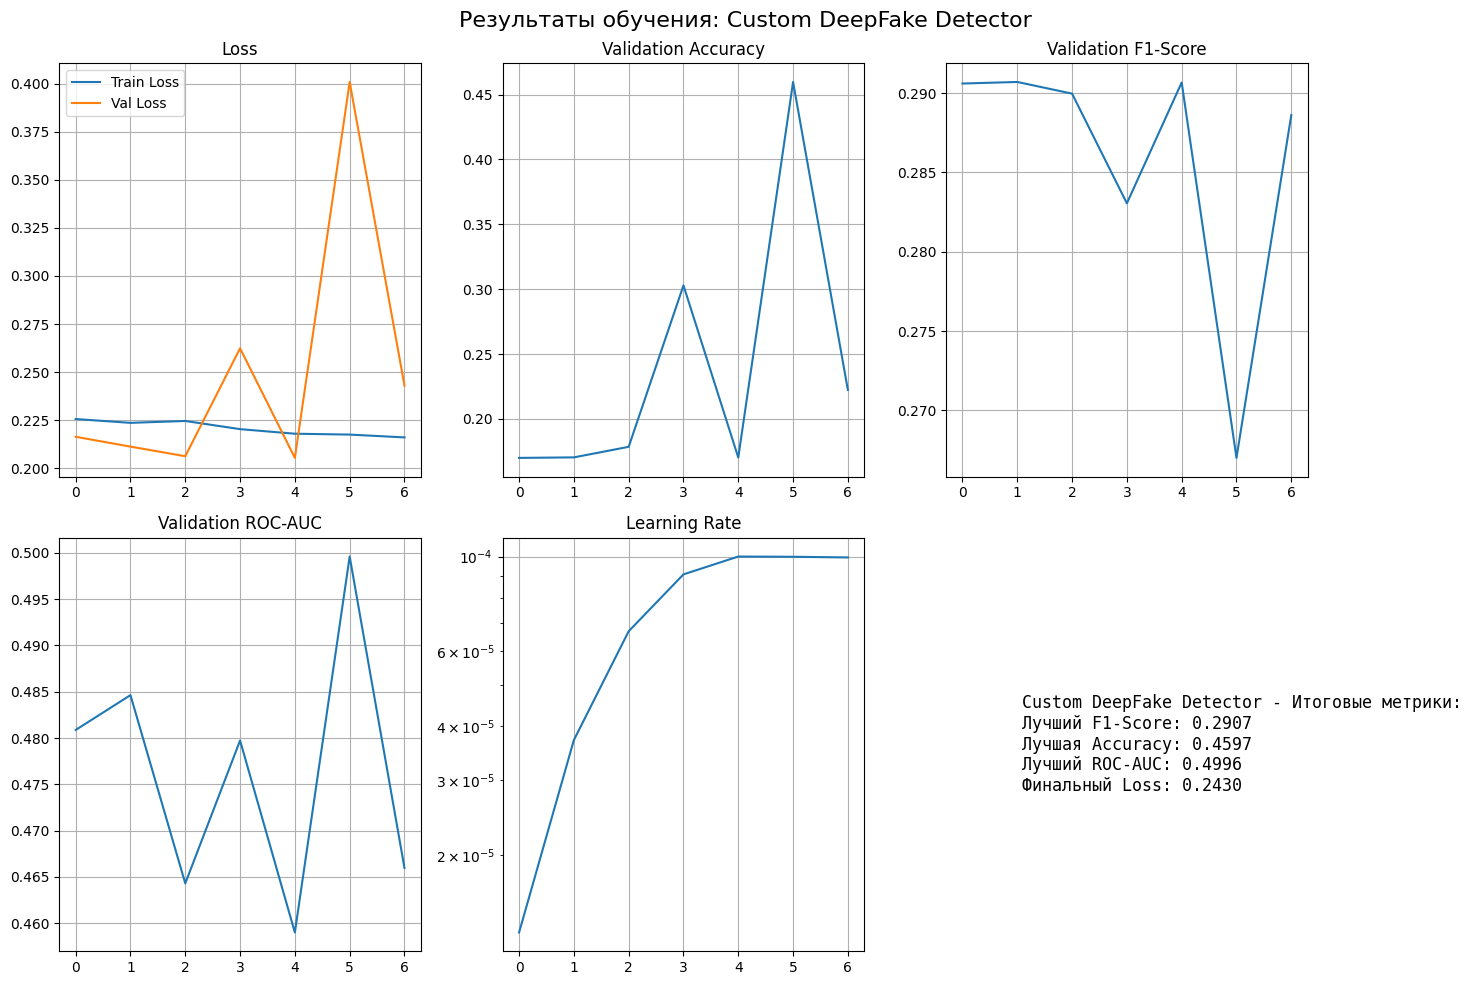

In [17]:
def plot_training_history(history, model_name="Custom Model"):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    axes[0, 0].plot(history['train_loss'], label='Train Loss')
    axes[0, 0].plot(history['val_loss'], label='Val Loss')
    axes[0, 0].set_title('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    axes[0, 1].plot(history['val_accuracy'])
    axes[0, 1].set_title('Validation Accuracy')
    axes[0, 1].grid(True)

    axes[0, 2].plot(history['val_f1'])
    axes[0, 2].set_title('Validation F1-Score')
    axes[0, 2].grid(True)

    axes[1, 0].plot(history['val_roc_auc'])
    axes[1, 0].set_title('Validation ROC-AUC')
    axes[1, 0].grid(True)

    axes[1, 1].plot(history['learning_rate'])
    axes[1, 1].set_title('Learning Rate')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True)

    axes[1, 2].axis('off')
    summary_text = f"""
    {model_name} - Итоговые метрики:
    Лучший F1-Score: {max(history['val_f1']):.4f}
    Лучшая Accuracy: {max(history['val_accuracy']):.4f}
    Лучший ROC-AUC: {max(history['val_roc_auc']):.4f}
    Финальный Loss: {history['val_loss'][-1]:.4f}
    """
    axes[1, 2].text(0.1, 0.5, summary_text, fontsize=12,
                    verticalalignment='center', fontfamily='monospace')

    plt.suptitle(f'Результаты обучения: {model_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_training_history(history_v3, "Custom DeepFake Detector")

# Итог

Pretrained модели (1 и 2) показали лучшие результаты, так как на их ртенировку было выделено значительно больше времени.
Тем не менее, у собственной модели (3) мы получили неплохие результаты (f1-score: ~0.3), в сравнении с потраченным на обучение временем.